In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from collections import defaultdict
from pathlib import Path

import torch

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

## Check performance against Interpro2GO

In [12]:
data_dir = Path("/weka/scratch/weka/kellislab/rcalef/data/magneton-data/evaluations/GeneOntology/")

path = data_dir / "interpro2go.txt"

go_to_interpro = defaultdict(list)
with open(path) as fh:
    for line in fh:
        if line.startswith("!"):
            continue
        interpro_id = line.split()[0].split(":")[-1]
        go_id = line.split(";")[-1].strip()
        go_to_interpro[go_id].append(interpro_id)


In [15]:

label_fname = data_dir / "nrPDB-GO_annot.tsv"
label_line = 1
with open(label_fname, "r") as f:
    all_labels = f.readlines()[label_line].strip("\n").split("\t")
labeller = LabelEncoder().fit(all_labels)
num_classes = len(labeller.classes_)

In [19]:
run_path = "/weka/scratch/weka/kellislab/rcalef/projects/magneton/experiments/downstream_evals/deepfri_prosst_orig/GO:MF/test_results.pt"
results = torch.load(run_path)

In [38]:
def get_per_label_fmax(
    run_path: Path,
) -> pd.DataFrame:
    results = torch.load(run_path)
    logits = results["logits"]
    labels = results["labels"]
    num_thresh_steps=101

    probs = logits.sigmoid()
    f1s = []
    thresh_vals = torch.linspace(start=0, end=1, steps=num_thresh_steps)
    for thresh in thresh_vals:
        preds = probs >= thresh

        tp = ((preds == labels) & labels).sum()
        fp = ((preds != labels) & labels).sum()
        tn = ((preds == labels) & ~labels).sum()
        fn = ((preds != labels) & ~labels).sum()

        f1 = (2*tp) / (2*tp + fp + fn)
        f1s.append(f1)

    f1s = torch.stack(f1s)
    fmax = f1s.max()
    best_thresh = thresh_vals[f1s.argmax()].item()
    print(fmax, best_thresh)

    preds = probs >= best_thresh

    tp = ((preds == labels) & labels).sum(dim=0)
    fp = ((preds != labels) & labels).sum(dim=0)
    fn = ((preds != labels) & ~labels).sum(dim=0)

    per_label_fmax = (2*tp) / (2*tp + fp + fn)

    return pd.DataFrame({
        "go_id": labeller.classes_.tolist(),
        "fmax": per_label_fmax.tolist(),
    })

In [40]:
got = get_per_label_fmax(run_path)
got.head()

tensor(0.6309) 0.05999999865889549


,go_id,fmax
0,GO:0000049,0.270270
1,GO:0000287,0.466019
2,GO:0000976,0.000000
3,GO:0000977,0.000000
4,GO:0000981,0.142857


In [41]:
orig_label_fmax = get_per_label_fmax("/weka/scratch/weka/kellislab/rcalef/projects/magneton/experiments/downstream_evals/deepfri_prosst_orig/no_ft/GO:MF/test_results.pt")
dom_label_fmax = get_per_label_fmax("/weka/scratch/weka/kellislab/rcalef/projects/magneton/experiments/downstream_evals/deepfri_prosst_domain_default_lr/no_ft/GO:MF/test_results.pt")

tensor(0.5387) 0.17999999225139618
tensor(0.5816) 0.23999999463558197


In [42]:
combined = (
    orig_label_fmax
    .merge(
        dom_label_fmax,
        on="go_id",
        suffixes=("_orig", "_dom")
    )
    .assign(
        fmax_diff=lambda x: x.fmax_dom - x.fmax_orig,
    )
)
combined.head()

,go_id,fmax_orig,fmax_dom,fmax_diff
0,GO:0000049,0.108108,0.263158,0.155050
1,GO:0000287,0.312500,0.407767,0.095267
2,GO:0000976,0.000000,0.000000,0.000000
3,GO:0000977,0.000000,0.000000,0.000000
4,GO:0000981,0.133333,0.210526,0.077193


<Axes: >

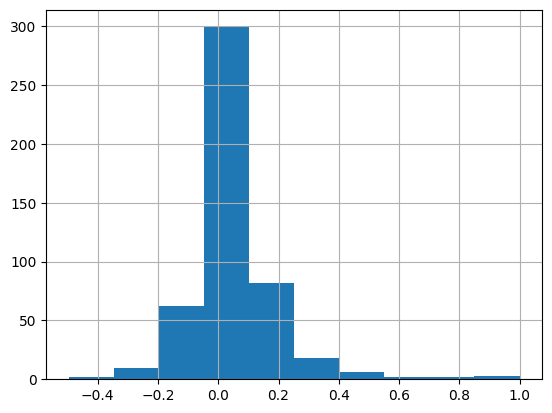

In [43]:
combined.fmax_diff.hist()

In [44]:
train_counts = pd.read_table("/weka/scratch/weka/kellislab/rcalef/data/magneton-data/interpro_103.0/seq_splits/train_sharded/summary_stats/Domain_summaries.tsv")
train_counts.head()

,element_id,element_name,count,max_occurences,min_len,max_len,avg_len,min_num_segs,max_num_segs,avg_num_segs,avg_coverage
0,IPR000001,Kringle,70,1,76.0,810.0,144.114286,1.0,10.0,1.771429,0.249973
1,IPR000007,"Tubby, C-terminal",41,1,53.0,340.0,253.585366,1.0,1.0,1.000000,0.583689
2,IPR000008,C2 domain,209,1,92.0,889.0,189.626794,1.0,7.0,1.502392,0.246526
3,IPR000010,Cystatin domain,135,1,31.0,713.0,124.392593,1.0,8.0,1.222222,0.771733
4,IPR000014,PAS domain,246,3,30.0,448.0,115.451220,1.0,4.0,1.369919,0.157227


In [45]:
def count_train_num(go_id: str) -> int:
    interpro_ids = pd.Series(go_to_interpro[go_id])

    want_rows = train_counts.loc[lambda x: x.element_id.isin(interpro_ids)]
    if len(want_rows) == 0:
        return 0
    return want_rows["count"].sum()

In [46]:
count_train_num("GO:0003677")

9171

In [47]:
combined = (
    combined
    .assign(
        train_count=lambda x: x.go_id.apply(count_train_num),
    )
)
combined.head()

,go_id,fmax_orig,fmax_dom,fmax_diff,train_count
0,GO:0000049,0.108108,0.263158,0.155050,1105
1,GO:0000287,0.312500,0.407767,0.095267,1377
2,GO:0000976,0.000000,0.000000,0.000000,67
3,GO:0000977,0.000000,0.000000,0.000000,148
4,GO:0000981,0.133333,0.210526,0.077193,378


<Axes: xlabel='train_count', ylabel='fmax_diff'>

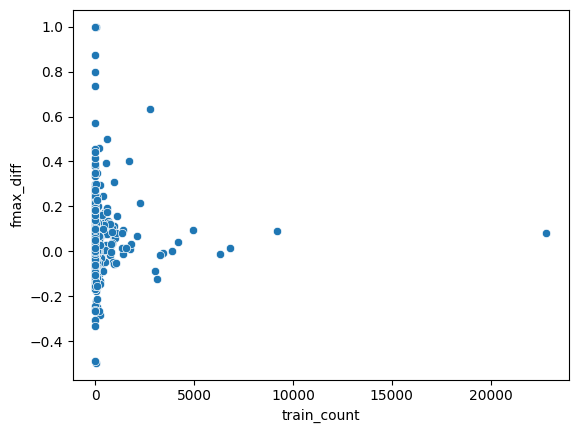

In [53]:
sns.scatterplot(x="train_count", y="fmax_diff", data=combined)
#plt.xscale("log")

In [ ]:
combined.train_count.describe()

count      489.000000
mean       264.425358
std       1289.921510
min          0.000000
25%          0.000000
50%          0.000000
75%         71.000000
max      22819.000000
Name: train_count, dtype: float64

Text(0.5, 1.0, 'GO:MF prediction improvement not trivially explained by InterPro2GO mapping')

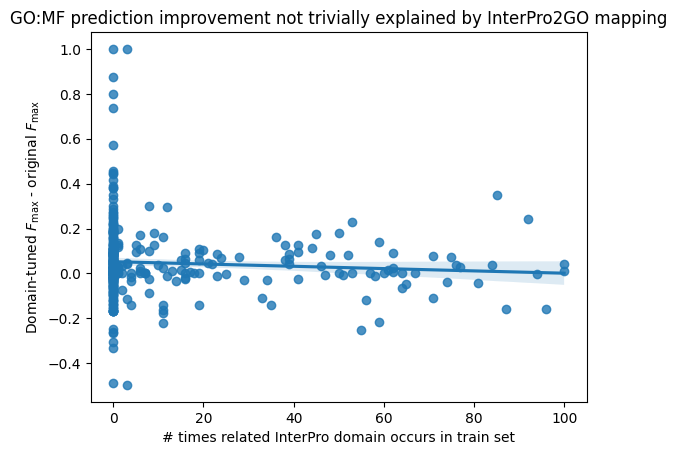

In [62]:
sns.regplot(
    x="train_count",
    y="fmax_diff",
    data=combined.query("train_count <= 100"),
)
plt.ylabel("Domain-tuned $F_{\max}$ - original $F_{\max}$")
plt.xlabel("# times related InterPro domain occurs in train set")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")
#plt.xscale("log")

In [64]:
combined = (
    combined
    .assign(
        in_train=lambda x: x.train_count != 0,
    )
)
combined.head()

,go_id,fmax_orig,fmax_dom,fmax_diff,train_count,in_train
0,GO:0000049,0.108108,0.263158,0.155050,1105,True
1,GO:0000287,0.312500,0.407767,0.095267,1377,True
2,GO:0000976,0.000000,0.000000,0.000000,67,True
3,GO:0000977,0.000000,0.000000,0.000000,148,True
4,GO:0000981,0.133333,0.210526,0.077193,378,True


Text(0.5, 1.0, 'GO:MF prediction improvement not trivially explained by InterPro2GO mapping')

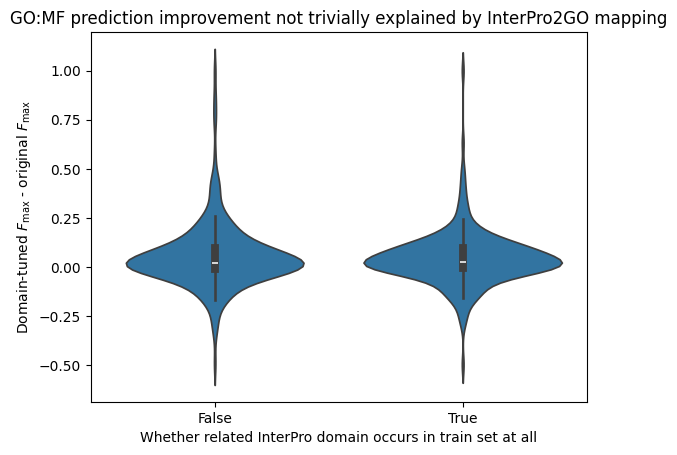

In [68]:
sns.violinplot(
    x="in_train",
    y="fmax_diff",
    data=combined,
)
plt.ylabel("Domain-tuned $F_{\max}$ - original $F_{\max}$")
plt.xlabel("Whether related InterPro domain occurs in train set at all")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")